In [1]:
import numpy as np
import tensorflow as tf

val_data = np.load("lorenz_val.npy")  # Shape: (num_val, train_steps, 3)
train_data = np.load("lorenz_train.npy")  # Shape: (num_train, train_steps, 3)
test_data = np.load("lorenz_test.npy")  # Shape: (num_test, test_steps, 3)

In [2]:
print("Validation data shape:",val_data.shape)
print("Train data shape:",train_data.shape)
print("Test data shape:",test_data.shape)

Validation data shape: (200, 256, 3)
Train data shape: (800, 256, 3)
Test data shape: (200, 1024, 3)


In [3]:
batch_size = 256
trajLength = 256 #length of each trajectory in the dataset
numTraj = 2048 #total number of trajectories in the dataset
numTraj_val = 64
input_dim = 3
S=255
num_batches_train = int(trajLength*numTraj/batch_size) ## num_batches = trajLength*numTraj/batch_size 
num_batches_val = int(trajLength*numTraj_val/batch_size)

In [4]:
print(num_batches_train)
print(num_batches_val)

2048
64


In [5]:
min_val = tf.reduce_min(val_data)
max_val = tf.reduce_max(val_data)

min_train = tf.reduce_min(train_data)
max_train = tf.reduce_max(train_data)

min_test = tf.reduce_min(test_data)
max_test = tf.reduce_max(test_data)

train_data = (train_data - min_train) / (max_train - min_train)
validation_data = (val_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
train_data = tf.reshape(train_data, (-1,3))
validation_data = tf.cast(validation_data, tf.float32)
validation_data = tf.reshape(validation_data, (-1,3))
validation_data = tf.data.Dataset.from_tensor_slices((validation_data, validation_data)).batch(batch_size)
test_data = tf.cast(test_data, tf.float32)

In [6]:
train_data

<tf.Tensor: shape=(204800, 3), dtype=float32, numpy=
array([[0.49850893, 0.10785561, 0.8396513 ],
       [0.4609208 , 0.10300861, 0.8047367 ],
       [0.42667395, 0.1023576 , 0.7772731 ],
       ...,
       [0.36603907, 0.28816524, 0.7445737 ],
       [0.35863316, 0.28888157, 0.7343152 ],
       [0.3520045 , 0.28955418, 0.72469634]], dtype=float32)>

In [7]:
validation_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [8]:
from tensorflow import keras
import math

In [9]:
n_embd=32
n_head=4

class MLP(tf.keras.layers.Layer):
    def __init__(self, n_state, dropout_rate=0.1):
        super(MLP, self).__init__()
        self.n_embd = n_embd
        self.dense1 = tf.keras.layers.Dense(n_state)
        self.dense2 = tf.keras.layers.Dense(n_embd)
        self.dropout = tf.keras.layers.Dropout(rate=dropout_rate)
    
    def gelu(self, x):
        return 0.5 * x * (1.0 + tf.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * tf.pow(x, 3.0))))
    
    def call(self, x, training=False):
        x = self.gelu(self.dense1(x))
        x = self.dense2(x)
        return self.dropout(x, training=training)

In [10]:
class EncoderModel(keras.Model):
    def __init__(self):
        super().__init__()
        self.norm = tf.keras.layers.LayerNormalization(epsilon=1e-5)
        self.n_embd = n_embd
        self.mlp = MLP(4 * n_embd)  # Ensure MLP is a properly defined class
        self.attn = tf.keras.layers.MultiHeadAttention(num_heads=n_head, key_dim=n_embd)
        self.attn_dense = tf.keras.layers.Dense(n_embd * 3)
        self.eta = tf.keras.layers.Dense(n_embd)

    def call(self, x, layer_past=None, attention_mask=None, head_mask=None, use_cache=False, output_attentions=False):
        # phi(eta(x))
        #outer encoder (eta)
        x = self.eta(x) 
        
        #inner encoder (phi)
        x_new = self.attn_dense(x)
        query, key, value = tf.split(x_new, 3, axis=2)
        # Residual Connection 1
        out_attn = self.attn(query=query, value=value, key=key, return_attention_scores=False)
        
        x1 = x + out_attn[0]

        # Apply LayerNorm 
        norm_x = self.norm(x1) 

        # MLP Processing
        m = self.mlp(norm_x)

        # Residual Connection 2
        outputs = x1 + m
        
        return outputs[0], x


In [11]:
# Koopman Layer
class KoopmanLayer(keras.layers.Layer):
    def __init__(self, S):
        super(KoopmanLayer, self).__init__()
        self.S = S

    def build(self, input_shape):
        latent_dim = input_shape[-1]
        self.K = self.add_weight(
            name="Koopman_weight",
            shape=(latent_dim, latent_dim),
            initializer="random_normal",
            trainable=True,
        )

    def call(self, Z):
        len = tf.shape(Z)[0]
        trajLength = len
        latent_dim = tf.shape(Z)[1]
        
        if len>self.S:
            Z1 = Z[0:self.S+1]
            trajLength = self.S
        else:
            Z1 = Z

        z_shift = Z[1:trajLength+1,:]
        z_first = Z[0,:]
        # Compute Z2_tilde using matrix multiplication with K
        Z2_tilde = tf.zeros([trajLength, latent_dim], dtype=tf.float32)
        
        for m in range(trajLength - 1):  # 0 to trajLength-2
            indices = tf.constant([[m]])  # Use `m` directly as index
            if m == 0:
                # First step, apply Koopman operator to z_first
                updates = [tf.linalg.matvec(self.K, z_first)]
            else:
                # Subsequent steps, apply Koopman operator to z_shift
                updates = [tf.linalg.matvec(self.K, z_shift[m, :])]

            # Update Z2_tilde with computed values
            Z2_tilde = tf.tensor_scatter_nd_update(Z2_tilde, indices, updates)

        return Z, Z2_tilde, z_shift

# Koopman Model
class KoopmanModel(keras.Model):
    def __init__(self, S):
        super(KoopmanModel, self).__init__()
        self.koopman = KoopmanLayer(S)

    def call(self, z):
        z, Z2_tilde, z_shift = self.koopman(z) 
        
        #z: Latent variables of x in the lifted space
        #z2_tilde: Latent variables of prediction obtained by linearity from K (z2_tilde = K^m * z(1,:))
        
        return z,Z2_tilde,z_shift  # Pass only transformed output to the decoder

In [12]:
class DecoderModel(keras.Model):
    def __init__(self):
        super().__init__()
        self.norm = tf.keras.layers.LayerNormalization(epsilon=1e-5)
        self.n_embd = n_embd
        self.mlp = MLP(4 * n_embd)  # Same as in the encoder
        self.attn = tf.keras.layers.MultiHeadAttention(num_heads=n_head, key_dim=n_embd)
        self.attn_dense = tf.keras.layers.Dense(n_embd * 3)
        self.dense = tf.keras.layers.Dense(n_embd) 
        self.output_layer = tf.keras.layers.Dense(input_dim, activation="sigmoid")  # Adjust activation as needed

    def call(self, x1, x2, x3, attention_mask=None, head_mask=None, output_attentions=False):
        #eta_inverse(xi(x))
        #inner decoder(xi)
        x1 = tf.expand_dims(x1, axis=0) 
        x2 = tf.expand_dims(x2, axis=0) 

        x1 = self.dense(x1)
        x_new1 = self.attn_dense(x1)
        query1, key1, value1 = tf.split(x_new1, 3, axis=2)

        # Residual Connection 1
        out_attn1 = self.attn(query=query1, value=value1, key=key1, return_attention_scores=False)
        
        x1 = x1 + out_attn1[0]

        # Apply second LayerNorm 
        norm_x1 = self.norm(x1)  

        # MLP Processing
        m1 = self.mlp(norm_x1)

        # Residual Connection 2
        outputs1 = x1 + m1

        x2 = self.dense(x2)
        x_new2 = self.attn_dense(x2)
        query2, key2, value2 = tf.split(x_new2, 3, axis=2)

        # Residual Connection 1
        out_attn2 = self.attn(query=query2, value=value2, key=key2, return_attention_scores=False)
        
        x2 = x2 + out_attn2[0]

        # Apply second LayerNorm 
        norm_x2 = self.norm(x2)  

        # MLP Processing
        m2 = self.mlp(norm_x2)

        # Residual Connection 2
        outputs2 = x2 + m2
        
        #outer decoder(eta_inverse)
        return self.output_layer(outputs1)[0], self.output_layer(outputs2)[0], outputs1, self.output_layer(x3)[0]


In [13]:
class Koopman_AE_Model(keras.Model):
    """
    Custom Model to create a Koopman Autoencoder
    
    Parameters
    ----------
    input: tensor 
        x - the the orignal state inputs x given as snapshots taken from random trajectory
    
    Return
    ----------
    x_hat: tensor
        Reconstuction of the orignal state inputs x (label values are x)
    
    x2_hat: tensor
        Predcition of the original state inputs x (label values are forward time shifted x)
    
    x2_tilde: tensor
        Prediction obtained by linearity from K 
    """
    
    def __init__(self, S, name=None):
        super(Koopman_AE_Model, self).__init__(name=name)
        self.enc = EncoderModel()
        self.koopman = KoopmanModel(S)
        self.dec = DecoderModel()

    def call(self, input):
        x = input
        z, x_encOut = self.enc(x)
        z, z2_tilde, z2 = self.koopman(z)
        x_hat, x2_tilde, x_encOut1, x_encOut2 = self.dec(z, z2_tilde, x_encOut)
        return x_hat, x2_tilde, z2_tilde, z2, x_encOut, x_encOut1, x_encOut2


In [14]:
import time

class MyStaticModel():
    def __init__(self, input_dim, batch_size, S, num_batches_train, num_batches_val):
        # Initialize constants
        self.batch_size = batch_size
        self.S = S
        self.num_batches_train = num_batches_train
        self.num_batches_val = num_batches_val

        self.inputs = tf.keras.layers.Input(shape=(input_dim,))
        
    ######################################  LOSS FUNCTIONS  ###################################################

    def tot_loss(self, model, x, x_hat, x2_tilde, z2, z2_tilde, x_encOut, x_encOut1, x_encOut2): #To be changed
        """Calculates total loss as sum of recon_loss + predict_loss + Koopman_loss"""
        alpha = 1e-6
        
        x2 = x[1:self.S+1]
        
        recon_loss = tf.reduce_mean(tf.square(tf.subtract(x,x_hat))) #Loss 1
        predict_loss =tf.reduce_mean(tf.square(tf.subtract(x2,x2_tilde))) #Loss 2
        weights  = model.trainable_variables
        lossL2 = tf.add_n([tf.nn.l2_loss(w) for w in weights if 'bias' not in w.name])
        enc_loss = tf.reduce_mean(tf.square(tf.subtract(z2,z2_tilde))) #Loss 3
        innerEnc_loss = tf.reduce_mean(tf.square(tf.subtract(x_encOut,x_encOut1))) #Loss 4
        outerEnc_loss = tf.reduce_mean(tf.square(tf.subtract(x,x_encOut2))) #Loss 4
        
        return recon_loss + predict_loss + alpha*lossL2 + enc_loss + innerEnc_loss + outerEnc_loss 
    ###############################################     FIT FUNCTION        #########################################################

    def fit(self, model, x, y, validation_data, batch_size):
        # Preprocess data
        train_ds = tf.data.Dataset.from_tensor_slices((x, y)).batch(batch_size)
        # Define the optimizer
        optimizer = tf.keras.optimizers.Adam(0.0001)

        epochs = 20
        
        epoch_train_loss = [] # total loss for each epoch
        epoch_validation_loss = []

        start_time_total = time.time()
        for epoch in range(epochs):
                
            print("\nStart of epoch %d" % (epoch))
            start_time = time.time()

            batch_train_loss_list = [] # total loss for each batch 
            batch_validation_loss_list = []

            epoch_train_min_loss = []
            epoch_train_max_loss = []
            epoch_validation_min_loss = []
            epoch_validation_max_loss = []

            ###############################################     Training loop     ###################################################
            # Iterate over the train batches of the dataset.
            for step, (x_batch_train, y_batch_train) in enumerate(train_ds):
                
                with tf.GradientTape() as tape:
                    
                    x_batch_train = tf.reshape(x_batch_train, (1, 256, 3))
                    reconstruction, linearity, z2, z2_tilde, x_encOut, x_encOut1, x_encOut2 = model(x_batch_train)
                    # total avg loss for each batch
                    batch_train_loss = self.tot_loss(model, y_batch_train, reconstruction, linearity, z2, z2_tilde, x_encOut, x_encOut1, x_encOut2)
                    batch_train_loss_list.append(batch_train_loss)

                grads = tape.gradient(batch_train_loss, model.trainable_variables)
                optimizer.apply_gradients(zip(grads, model.trainable_variables))
                              
            # outside batch loop
            avg_train_loss = np.sum(batch_train_loss_list)/self.num_batches_train
            avg_min_train_loss = np.amin(batch_train_loss_list)/self.num_batches_train
            avg_max_train_loss = np.amax(batch_train_loss_list)/self.num_batches_train

            epoch_train_loss.append(avg_train_loss)
            epoch_train_min_loss.append(avg_min_train_loss)
            epoch_train_max_loss.append(avg_max_train_loss)
            print("Average training loss at epoch %d: %.7f"% (epoch, float(avg_train_loss)))


            ###############################################   Validaiton  loop     ###################################################
            for step, (x_batch_val, y_batch_val) in enumerate(validation_data):
                x_batch_val  = tf.reshape(x_batch_val, (1, 256, 3))
                reconstruction_val, linearity_val, z2, z2_tilde, x_encOut, x_encOut1, x_encOut2 = model(x_batch_val)
                batch_validation_loss = self.tot_loss(model, y_batch_val, reconstruction_val, linearity_val, z2, z2_tilde, x_encOut, x_encOut1, x_encOut2  )
                batch_validation_loss_list.append(batch_validation_loss)

            # outside batch loop
            epoch_validation_loss.append(np.sum(batch_validation_loss_list)/self.num_batches_val)
            epoch_validation_min_loss.append(np.amin(batch_validation_loss_list)/self.num_batches_val)
            epoch_validation_max_loss.append(np.amax(batch_validation_loss_list)/self.num_batches_val)

            print(f"Epoch val loss: {np.sum(batch_validation_loss_list)/num_batches_val}")
            print("Time taken: %.2fs" % (time.time()- start_time_total))

        print("Total time taken: %.2fs" % (time.time() - start_time_total))



In [15]:
Training_class = MyStaticModel(input_dim, batch_size, S, num_batches_train, num_batches_val)
koopmanAEModel = Koopman_AE_Model(S)
Training_class.fit(koopmanAEModel,x=train_data, y=train_data, validation_data=validation_data, batch_size=batch_size)


Start of epoch 0
Average training loss at epoch 0: 0.0285269
Epoch val loss: 0.09210994094610214
Time taken: 628.37s

Start of epoch 1
Average training loss at epoch 1: 0.0087825
Epoch val loss: 0.06512779742479324
Time taken: 1297.60s

Start of epoch 2
Average training loss at epoch 2: 0.0071377
Epoch val loss: 0.057443778961896896
Time taken: 2086.16s

Start of epoch 3
Average training loss at epoch 3: 0.0063724
Epoch val loss: 0.052141305059194565
Time taken: 2888.54s

Start of epoch 4
Average training loss at epoch 4: 0.0056977
Epoch val loss: 0.04670103266835213
Time taken: 3699.87s

Start of epoch 5
Average training loss at epoch 5: 0.0050478
Epoch val loss: 0.041053153574466705
Time taken: 4496.69s

Start of epoch 6
Average training loss at epoch 6: 0.0044301
Epoch val loss: 0.03568882867693901
Time taken: 5300.94s

Start of epoch 7
Average training loss at epoch 7: 0.0038502
Epoch val loss: 0.030436590313911438
Time taken: 6085.40s

Start of epoch 8
Average training loss at ep

In [16]:
K = koopmanAEModel.koopman.get_weights()
print(K) 

[array([[ 0.03946227, -0.0070535 ,  0.01802418, ...,  0.03541111,
         0.04625574,  0.02553884],
       [ 0.03635963,  0.04526085,  0.13826214, ..., -0.00511394,
        -0.06777669, -0.01778667],
       [-0.05203449,  0.08541364,  0.2594767 , ...,  0.0973344 ,
         0.06741478,  0.12722416],
       ...,
       [-0.08229832,  0.09496036,  0.08459339, ...,  0.08890618,
         0.00466129,  0.07501684],
       [ 0.14814489, -0.0412378 ,  0.10918492, ...,  0.09107383,
         0.20303556, -0.03911737],
       [-0.18232122, -0.03480178,  0.11233304, ...,  0.13062863,
         0.07363278,  0.16732615]], dtype=float32)]


In [17]:
test_data.shape

TensorShape([200, 1024, 3])

In [124]:
test_data = tf.reshape(test_data, (-1,3))

In [125]:
test_data.shape

TensorShape([204800, 3])

In [126]:
res=koopmanAEModel(tf.reshape(test_data[:batch_size ],(1,256,3)))

In [127]:
test_data[:batch_size]

<tf.Tensor: shape=(256, 3), dtype=float32, numpy=
array([[0.34151366, 0.34737244, 0.5447186 ],
       [0.3419654 , 0.3451709 , 0.5399159 ],
       [0.34216526, 0.3429859 , 0.53526133],
       [0.3421366 , 0.34078515, 0.5307527 ],
       [0.34189898, 0.33853608, 0.526389  ],
       [0.34146884, 0.33620545, 0.5221706 ],
       [0.34085354, 0.3337651 , 0.5180988 ],
       [0.34005606, 0.33118752, 0.514176  ],
       [0.3390782 , 0.32844254, 0.5104066 ],
       [0.33792052, 0.32549745, 0.50679636],
       [0.33658242, 0.32231686, 0.50335294],
       [0.33505952, 0.31886497, 0.5000869 ],
       [0.33333963, 0.31510916, 0.4970103 ],
       [0.33140934, 0.31101367, 0.49413675],
       [0.32925358, 0.30653957, 0.49148557],
       [0.3268554 , 0.3016449 , 0.48908168],
       [0.3241961 , 0.29628465, 0.4869556 ],
       [0.32125515, 0.29041082, 0.48514357],
       [0.31801054, 0.28397974, 0.48369163],
       [0.3144363 , 0.27696678, 0.48266557],
       [0.3104988 , 0.2692911 , 0.48211145],
     

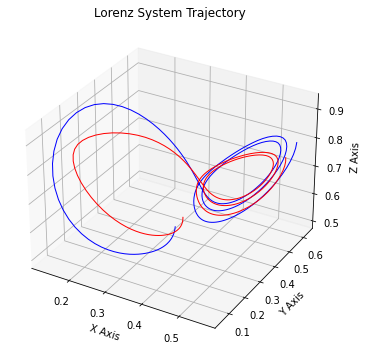

In [128]:
#Autoencoder output and actual output comparison

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Select a sample trajectory from the training data
actual_trajectory = test_data[:batch_size]
obtained_trajectory = res[0]
# Extract x, y, z components
x, y, z = actual_trajectory[:, 0], actual_trajectory[:, 1], actual_trajectory[:, 2]
x1, y1, z1 = obtained_trajectory[:, 0], obtained_trajectory[:, 1], obtained_trajectory[:, 2]
# Plot the Lorenz attractor
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, lw=1, color='b')
ax.plot(x1, y1, z1, lw=1, color='r')

ax.set_title("Lorenz System Trajectory")
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")

plt.show()


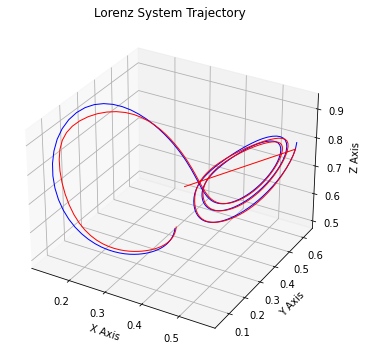

In [129]:
actual_trajectory = test_data[1:batch_size]
obtained_trajectory = res[1]
# Extract x, y, z components
x, y, z = actual_trajectory[:, 0], actual_trajectory[:, 1], actual_trajectory[:, 2]
x1, y1, z1 = obtained_trajectory[:, 0], obtained_trajectory[:, 1], obtained_trajectory[:, 2]
# Plot the Lorenz attractor
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, lw=1, color='b')
ax.plot(x1, y1, z1, lw=1, color='r')

ax.set_title("Lorenz System Trajectory")
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")

plt.show()


In [132]:
def find_loss(x, x_hat, x2_tilde):
    alpha1 = 1.0
    alpha2 = 10.0

    x2 = x[1:S+1]

    recon_loss = tf.reduce_mean(tf.square(tf.subtract(x,x_hat)))
    predict_loss =tf.reduce_mean(tf.square(tf.subtract(x2,x2_tilde)))


    return recon_loss, predict_loss, alpha1*recon_loss + alpha2*predict_loss 

In [133]:
batch_test_loss_list=[]
batch_recon_loss_list=[]
batch_predict_loss_list=[]

test_ds = tf.data.Dataset.from_tensor_slices((test_data, test_data)).batch(batch_size)

for step, (x_batch_test, y_batch_test) in enumerate(test_ds):
    
    reconstruction, linearity=koopmanAEModel(x_batch_test)
    # total avg loss for each batch
    recon_loss, predict_loss, tot_loss = find_loss(y_batch_test, reconstruction, linearity)
    batch_test_loss_list.append(tot_loss)
    batch_recon_loss_list.append(recon_loss)
    batch_predict_loss_list.append(predict_loss)
                    
avg_test_loss = np.sum(batch_test_loss_list)
avg_predict_loss = np.sum(batch_predict_loss_list)
avg_recon_loss = np.sum(batch_recon_loss_list)

print("Average test loss: ",float(avg_test_loss))
print("Average recon loss: ",float(avg_recon_loss))
print("Average predict loss: ",float(avg_predict_loss))

Average test loss:  5.137569427490234
Average recon loss:  0.5552151799201965
Average predict loss:  0.06254011392593384
